Quick demo of a radar water summary, using a classification trained elsewhere.

First, some boilerplate for using the (test) datacube.

In [1]:
%%bash
cat > radar.datacube << EOF
[default]
db_hostname: agdcdev-db.nci.org.au
db_port: 6432
db_database: radar
EOF

In [2]:
import datacube
import numpy as np

In [3]:
dc = {'wofs': datacube.Datacube(),
      'sar': datacube.Datacube(config='radar.datacube')}

Prepare region of interest, e.g. Lake George.

In [4]:
lat,lon = -35.15, 149.30

e = 0.01
lat = (lat+e,lat-e)
lon = (lon+e,lon-e)

In [5]:
lat = -35,97, -35.21
lon = 149.36, 149.49

In [6]:
%%time
radar = dc['sar'].load(product='s1_gamma0_scene', lat=lat, lon=lon,
                       output_crs='epsg:3577', resolution=(25,-25))

CPU times: user 4.73 s, sys: 24.3 s, total: 29 s
Wall time: 3min 34s


In [7]:
radar.vv.mean(dim='time').plot(vmax=0.05)

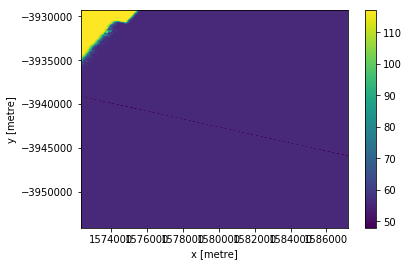

In [8]:
zeroish = 0.0001
nodata = (radar.vv < zeroish) & (radar.vh < zeroish)
clean = radar.copy(deep=True)
clean.vv.values[nodata.values] = np.nan
clean.vh.values[nodata.values] = np.nan
count = (~nodata).sum(dim='time')
count.plot()

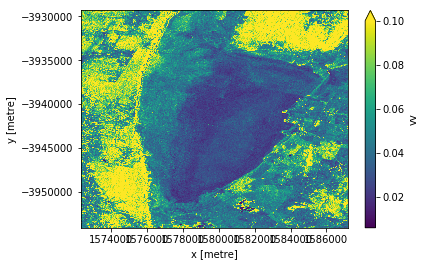

In [9]:
clean.vv.mean(dim='time').plot(vmax=0.1)

In [10]:
threshold = (clean.vv + clean.vh < 0.01)
water = threshold + 0.0
water.values[nodata.values] = np.nan

In [11]:
water.shape

(197, 990, 597)

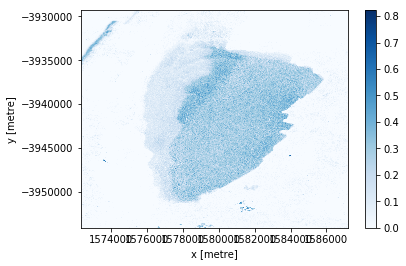

In [13]:
water.mean(dim='time').plot(cmap='Blues')

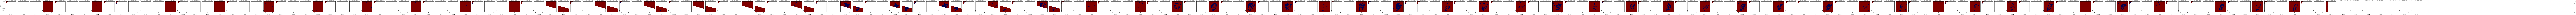

In [15]:
water[:,::10,::10].plot(col='time', cmap='seismic_r')

Notice that the above results are grainy/speckly, and parts of the lake interior are deemed to be often dry.

To address this, try excluding any ambiguous observations:

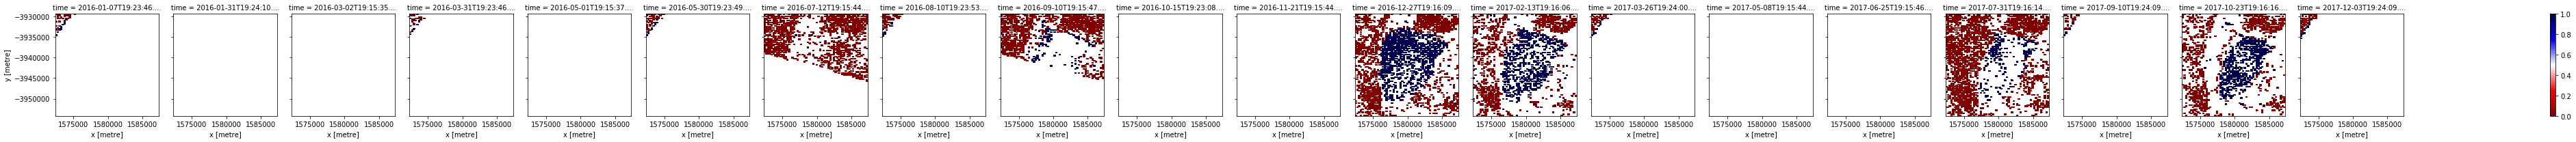

In [13]:
water = (clean.vv + clean.vh) < 0.008
dry = (clean.vv + clean.vh) > 0.1
unsure = ~water & ~dry

water = water + 0.0 # cast boolean to float
water.values[nodata.values] = np.nan
water.values[unsure.values] = np.nan

water[::10,::10,::10].plot(col='time', cmap='seismic_r')

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


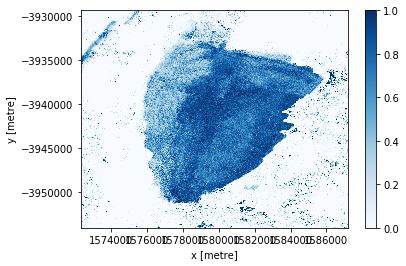

In [14]:
water.mean(dim='time').plot(cmap='Blues')

Now compare with Landsat-derived WOfS over the same period.

In [15]:
water.time.min().values, water.time.max().values, len(water.time)

(numpy.datetime64('2016-01-07T19:23:46.507857000'),
 numpy.datetime64('2017-12-27T19:24:08.276281000'),
 197)

In [16]:
%%time
landsat = dc['wofs'].load(product='wofs_albers', like=radar, time=['2016','2017'])

/g/data/v10/public/modules/dea/20181015/lib/python3.6/site-packages/datacube/api/query.py:93: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if like:


CPU times: user 3.33 s, sys: 1.81 s, total: 5.14 s
Wall time: 8.57 s


In [17]:
landsat.time.min().values, landsat.time.max().values, len(landsat.time)

(numpy.datetime64('2016-01-21T23:50:22.500000000'),
 numpy.datetime64('2017-12-25T23:50:52.500000000'),
 133)

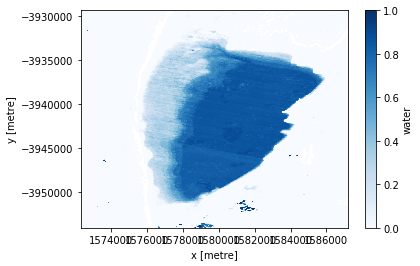

In [18]:
wet = landsat.water == 128
dry = landsat.water == 0
clear = wet | dry

(wet.sum(dim='time') / clear.sum(dim='time')).plot(cmap='Blues')

Landsat WOfS seems to provide a more clean result. Can also compare the number of observations used in either map.

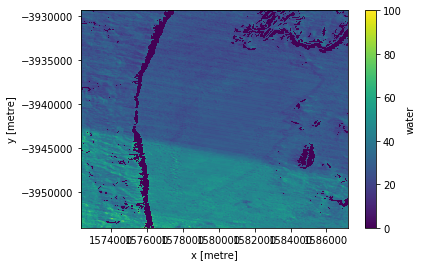

In [19]:
clear.sum(dim='time').plot(vmax=100) # Landsat WOfS clear count

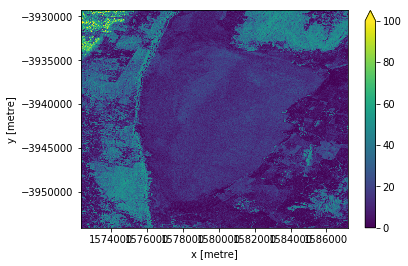

In [20]:
water.notnull().sum(dim='time').plot(vmax=100) # Radar "decisive observation" count